In [132]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.utils import resample
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import add_dummy_feature
from sklearn.decomposition import PCA

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import adjusted_rand_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier

import scikitplot as skplt
import mord

from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_curve, auc

### Load and Explore Data

In [2]:
df = pd.read_csv('winequality-red.csv', delimiter=';')

In [3]:
df.head()

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  
0      9.4        5  
1      9.8        5  
2      9.8        5  
3      9.8        6  
4      9.4        5

In [4]:
df.quality.value_counts(sort=False).sort_index()

3     10
4     53
5    681
6    638
7    199
8     18
Name: quality, dtype: int64

In [5]:
# Relabel
# df.quality = pd.cut(df.quality, bins=3, labels=[1, 2, 3]).astype('int')
df.quality = df.quality.map(lambda x: x-3)

In [6]:
df.quality.value_counts()

2    681
3    638
4    199
1     53
5     18
0     10
Name: quality, dtype: int64

In [7]:
corr = df.corr()

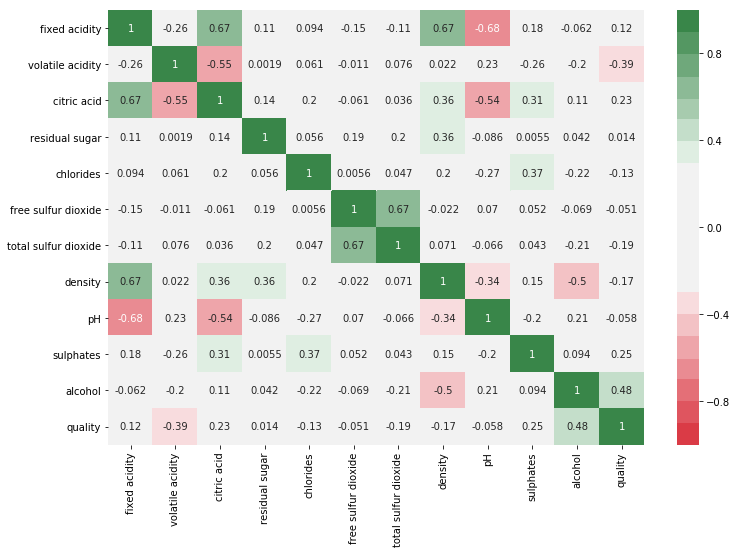

In [8]:
plt.figure(num=None, figsize=(12, 8))
sns.heatmap(corr, center=0, vmin=-1, vmax=1, cmap=sns.diverging_palette(10, 133, sep=80, n=20), annot=True)

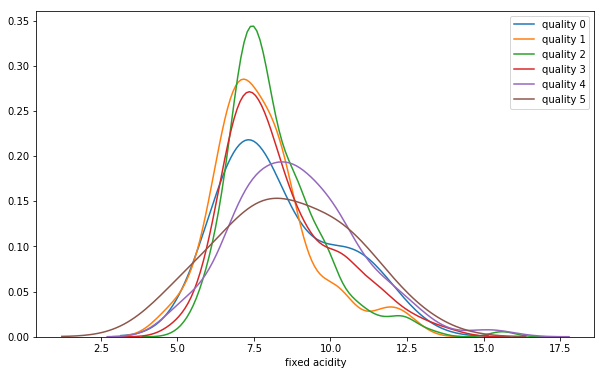

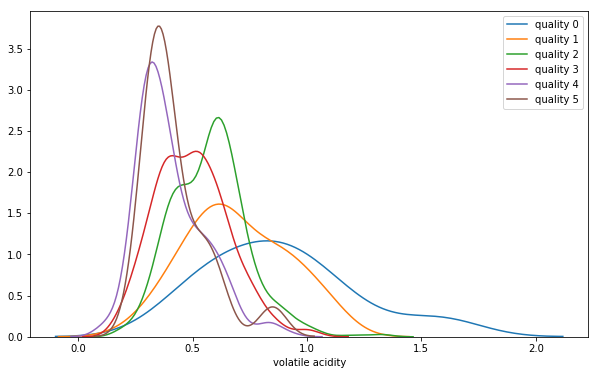

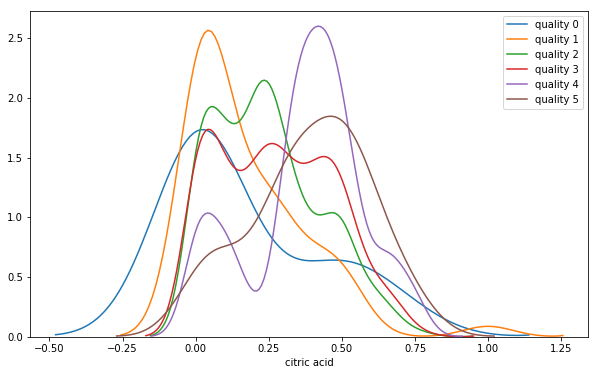

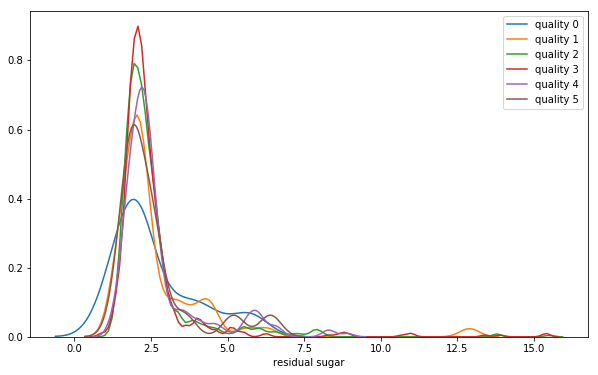

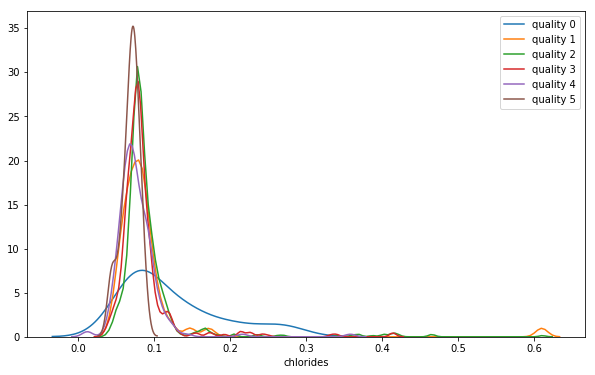

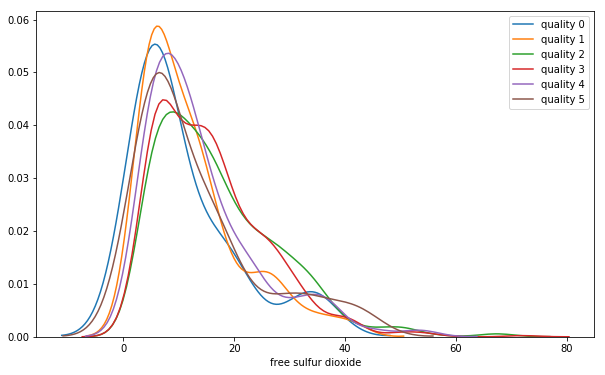

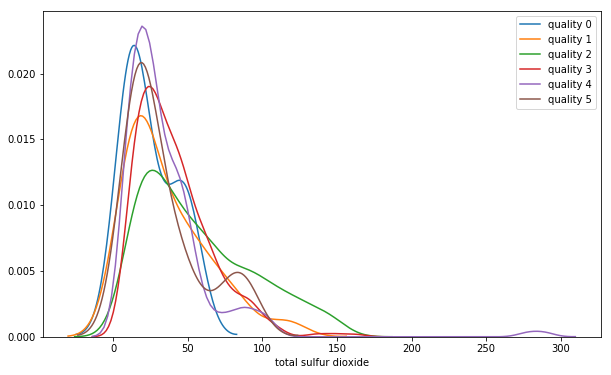

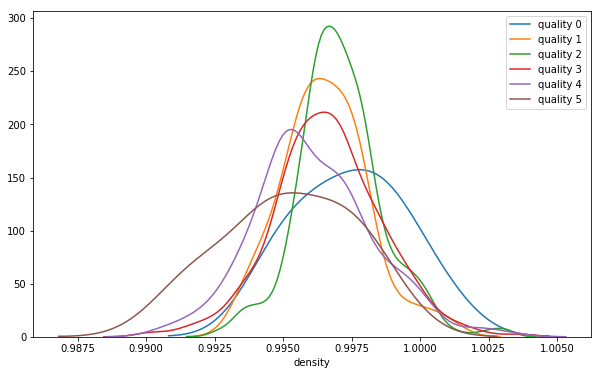

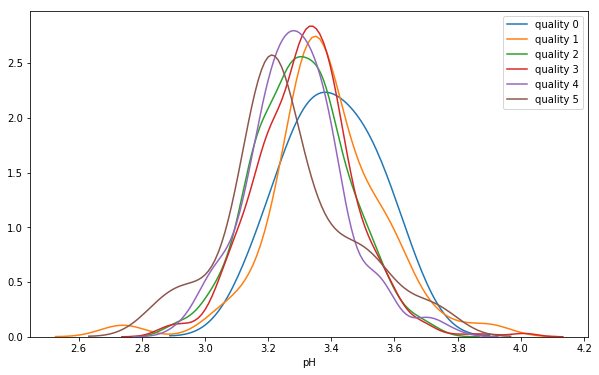

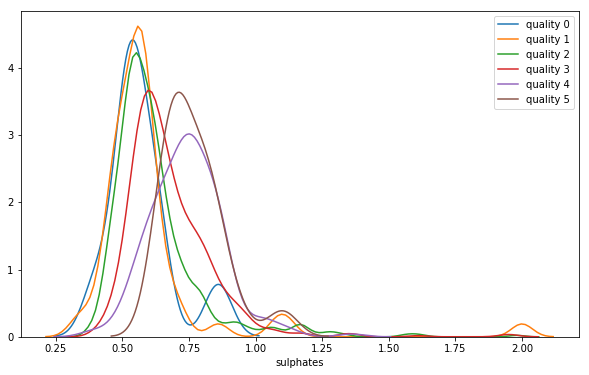

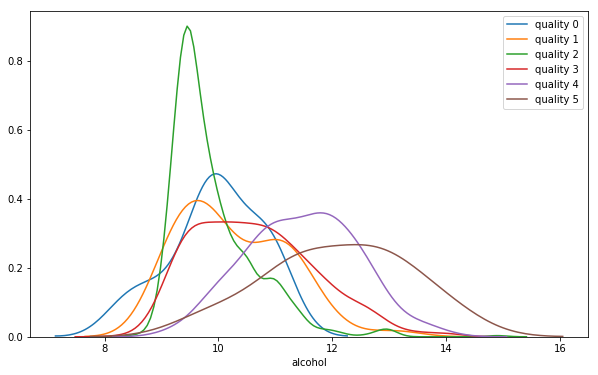

In [9]:
for f in df.columns[:-1]:
#     plt.figure(num=None, figsize=(10, 8))
    fig, ax = plt.subplots(figsize=(10, 6))
    for q in sorted(df.quality.unique()):
#         label = ('quality %d: %d' % (q, df[f][df.quality == q].count()))
        label = ('quality %d' % q)
        sns.distplot(df[f][df.quality == q], hist=False, label=label)
    plt.legend()

/home/cneiderer/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:494: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
/home/cneiderer/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


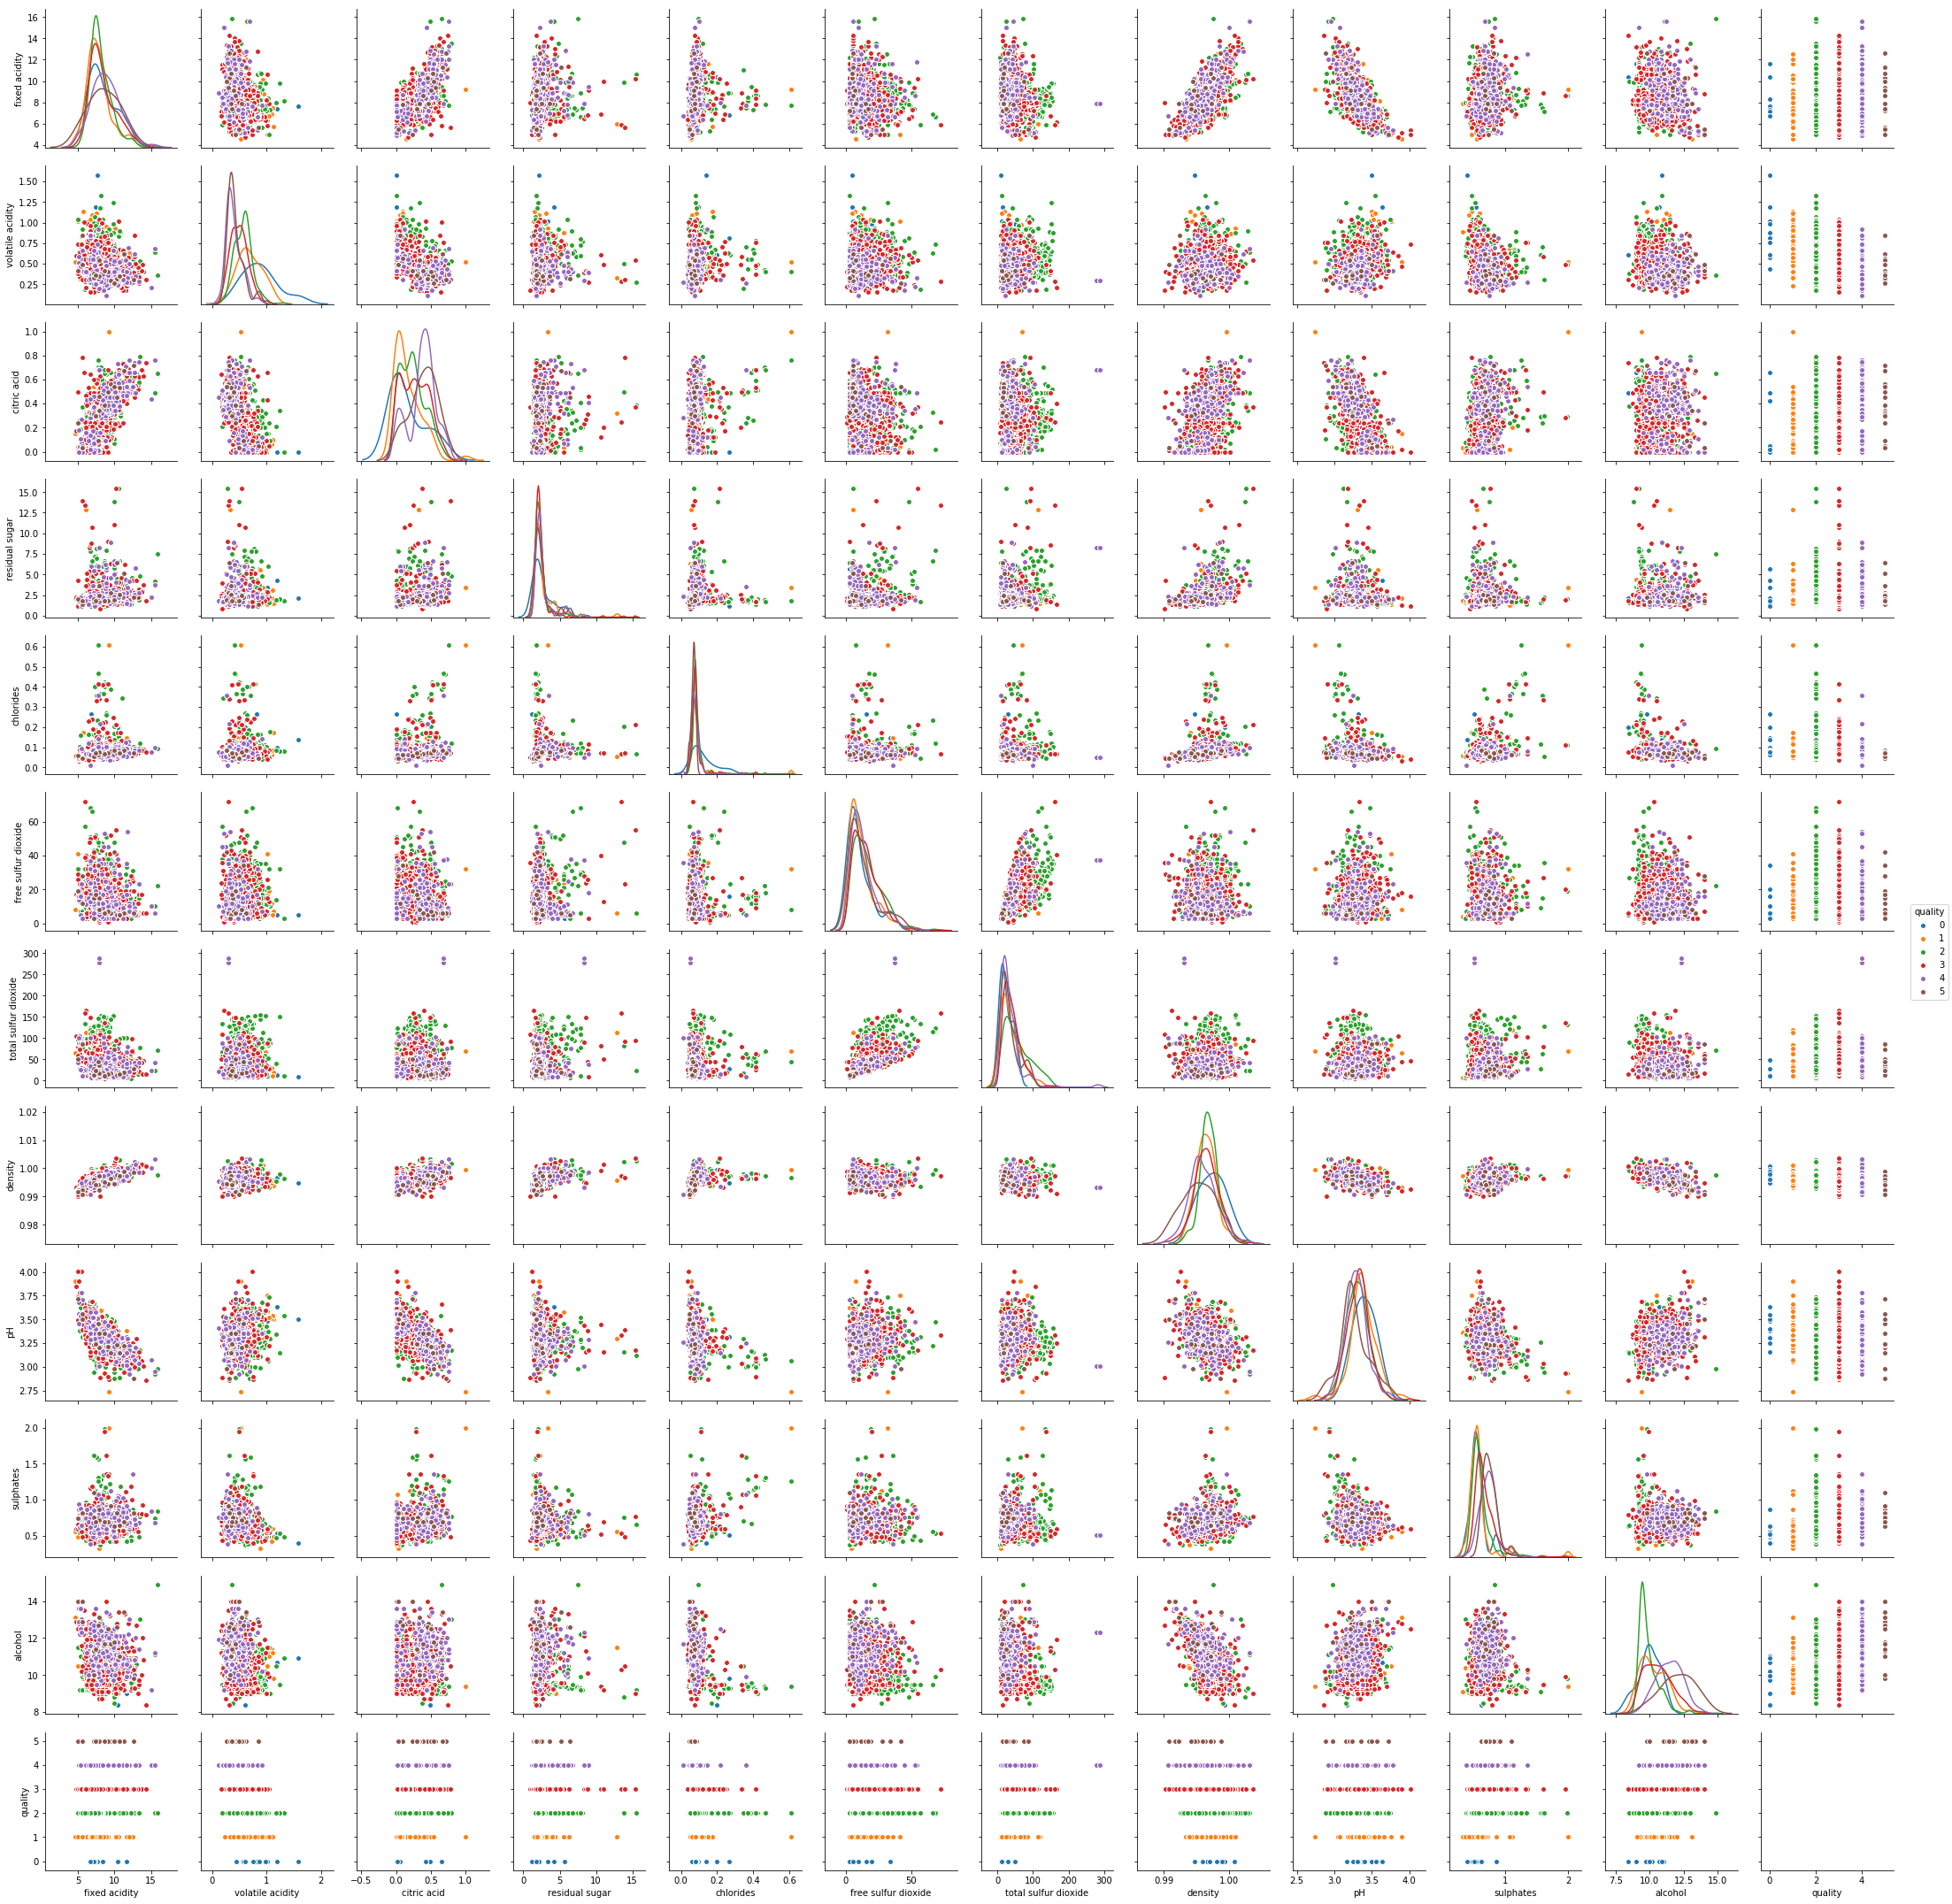

In [10]:
sns.pairplot(df, hue='quality', diag_kind='kde')

### Subset Data

In [11]:
df_subset = df.copy()
df_subset['quality2'] = pd.cut(df.quality, bins=3, labels=[1, 2, 3]).astype('int') #['good', 'medium', 'bad'])

In [12]:
df_subset.head()

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  quality2  
0      9.4        2         2  
1      9.8        2         2  
2      9.8        2         2  
3      9.8        3         2  
4      9.4        2         2

### Split Data 

In [66]:
# Split 
# y = resampled_df.quality
# X = resampled_df.drop(columns='quality')

# y = df_subset.quality2
# X = df_subset.drop(columns=['quality', 'quality2'])

y = df.quality
X = df.drop(columns='quality')

# X = df[['volatile acidity', 'citric acid', 'total sulfur dioxide', 'density', 'alcohol']]
# X = df[['volatile acidity', 'alcohol']]

# Make sure intercept exists
if ~any(X.columns == 'Intercept'):
    X.insert(0, 'Intercept', 1)
else: 
    X.Intercept = 1
    
# Stratified Split
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, stratify=y, test_size=.7, random_state=129)

In [151]:
def discrete_heatmap(cm):
    
    ### Discrete Confusion Matrix Heatmap
    from sklearn.preprocessing import normalize
    import matplotlib.pyplot as plt
    import seaborn as sns

    fig, ax = plt.subplots(figsize=(10, 6))

    # Normalize across predictions
    norm_Z = normalize(cm, axis=1)
    # Normalize across predictions and truth [Note: Use this if classes are balanced]
    norm_Z = (Z - np.min(Z)) / (np.max(Z) - np.min(Z))
    
    norm_Z = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    norm_Z = np.around(norm_Z, decimals=2)
    norm_Z[np.isnan(norm_Z)] = 0.0

    # Generate heatmap
    sns.heatmap(norm_Z, cmap='RdYlGn', annot=True, cbar=True)

    ## Format axes object
    #  Format X-axis label and ticks
    ax.set_xlabel('Predicted', fontdict={'size': 12})
    ax.xaxis.set_ticks_position('top') 
    ax.xaxis.set_label_position('top')
    # Format Y-axis label
    ax.set_ylabel('Truth', fontdict={'size': 12})
    # Format Title [Note: double newlines are to create space between Title and the X-axis label that was moved to the top]
    ax.set_title('Red Wine Quality Confusion Matrix\n\n', fontdict={'size': 14, 'weight': 'bold'})

In [152]:
def interpolated_heatmap(cm):
    
    ### Interpolated Confusion Matrix Heatmap
    import numpy as np
    from sklearn.preprocessing import normalize
    import matplotlib.pyplot as plt

    fig, ax = plt.subplots(figsize=(10, 6))

    # Normalize across predictions [Note: Use this if classes are imbalanced]
    norm_Z = normalize(cm, axis=1)
    # Normalize across predictions and truth [Note: Use this if classes are balanced]
    norm_Z = (Z - np.min(Z)) / (np.max(Z) - np.min(Z))
    
    norm_Z = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    norm_Z = np.around(norm_Z, decimals=2)
    norm_Z[np.isnan(norm_Z)] = 0.0

    # Generate X, Y indices of confusion matrix
    n_classes = norm_Z.shape[0]
    X, Y = np.meshgrid(np.arange(0, n_classes, 1), np.arange(n_classes-1, -1, -1))

    # Plot contours
    plt.contourf(X, Y, norm_Z, 25, cmap='RdYlGn')#, vmin=0, vmax=1)
    ax2 = plt.colorbar();

    ## Format X-axis label and ticks
    ax.set_xlabel('Predicted', fontdict={'size': 12})
    # Move ticks and label to top
    ax.xaxis.set_ticks_position('top') 
    ax.xaxis.set_label_position('top')
    # Hide major tick labels
    ax.set_xticklabels([], minor=False) 
    # Create minor ticks in between and label every other one
    ax.set_xticks([0.5, 1.5, 2.5, 3.5, 4.5], minor=True)
    ax.set_xticklabels(['Low', '', 'Med', '', 'High'], minor=True)

    ## Format Y-axis label and ticks
    ax.set_ylabel('Truth', fontdict={'size': 12})
    # Hide major tick labels
    ax.set_yticklabels([], minor=False)
    # Create minor ticks in between and label every other one
    ax.set_yticks([0.5, 1.5, 2.5, 3.5, 4.5], minor=True)
    ax.set_yticklabels(['High', '', 'Med', '', 'Low'], minor=True)

    # Format Title [Note: double newlines are to create space between Title and the X-axis label that was moved to the top]
    ax.set_title('Red Wine Quality\n\n', fontdict={'size': 14, 'weight': 'bold'})

### Build Models

In [153]:
lr2 = LogisticRegression(C=1e3, 
                         class_weight='balanced', 
                         random_state=129,
                         multi_class='ovr',
                         solver='liblinear')
pipe2 = make_pipeline(StandardScaler(), lr2)

pipe2.fit(X_train, y_train)

print(pipe2)

# make predictions
lr2_pred = pipe2.predict(X_test)
lr2_probas = pipe2.predict_proba(X_test)

# summarize the fit of the model
print(classification_report(y_test, lr2_pred))
print(confusion_matrix(y_test, lr2_pred))

Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logisticregression', LogisticRegression(C=1000.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=129,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))])
             precision    recall  f1-score   support

          0       0.00      0.00      0.00         7
          1       0.21      0.38      0.27        37
          2       0.66      0.69      0.68       477
          3       0.54      0.42      0.47       447
          4       0.37      0.44      0.40       139
          5       0.11      0.31      0.17        13

avg / total       0.55      0.53      0.54      1120

[[  0   3   4   0   0   0]
 [  1  14  12   8   1   1]
 [  6  32 330  92  14   3]
 [  3  16 143 186  85  14]
 [  0   2   9  54  61  13]
 [  0   0   0   4   5   4]]

In [154]:
lr2 = LogisticRegression(C=1e3, 
                         class_weight='balanced', 
                         random_state=129,
                         multi_class='ovr',
                         solver='liblinear')
lr2.fit(X_train, y_train)
# lr2.fit(X_train, y_train).decision_function(X_test, )

print(lr2)

# make predictions
lr2_pred = lr2.predict(X_test)
lr2_probas = lr2.predict_proba(X_test)

# summarize the fit of the model
print(classification_report(y_test, lr2_pred))
print(confusion_matrix(y_test, lr2_pred))

LogisticRegression(C=1000.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=129,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
             precision    recall  f1-score   support

          0       0.08      0.14      0.10         7
          1       0.19      0.35      0.25        37
          2       0.66      0.69      0.67       477
          3       0.53      0.45      0.49       447
          4       0.43      0.36      0.39       139
          5       0.09      0.31      0.14        13

avg / total       0.55      0.53      0.54      1120

[[  1   2   4   0   0   0]
 [  1  13  12   9   0   2]
 [  4  35 329  99   6   4]
 [  7  17 146 200  57  20]
 [  0   2   9  62  50  16]
 [  0   0   0   6   3   4]]


In [155]:
adjusted_rand_score(y_test, lr2_pred)

0.15630442052780594

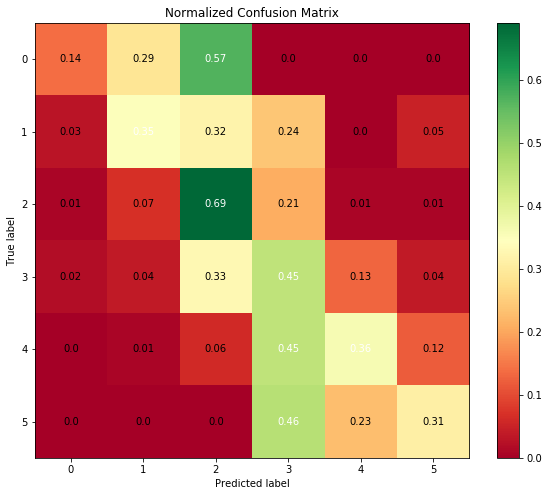

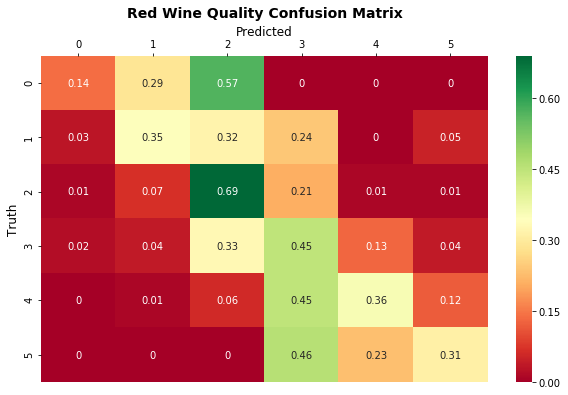

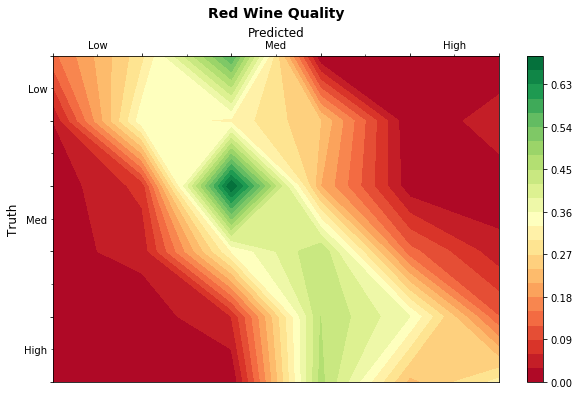

In [156]:
fig, ax = plt.subplots(figsize=(10, 8))
skplt.metrics.plot_confusion_matrix(y_test, lr2_pred, 
                                    normalize=True, cmap='RdYlGn', ax=ax)

discrete_heatmap(confusion_matrix(y_test, lr2_pred))

interpolated_heatmap(confusion_matrix(y_test, lr2_pred))

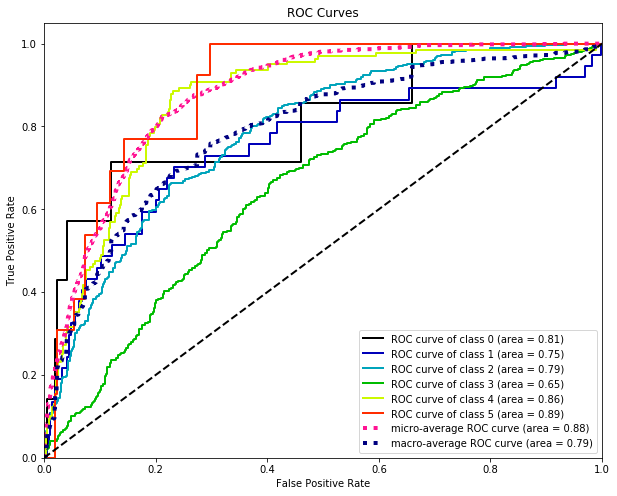

In [81]:
fig, ax = plt.subplots(figsize=(10, 8))
skplt.metrics.plot_roc_curve(y_test, lr2_probas, ax=ax)

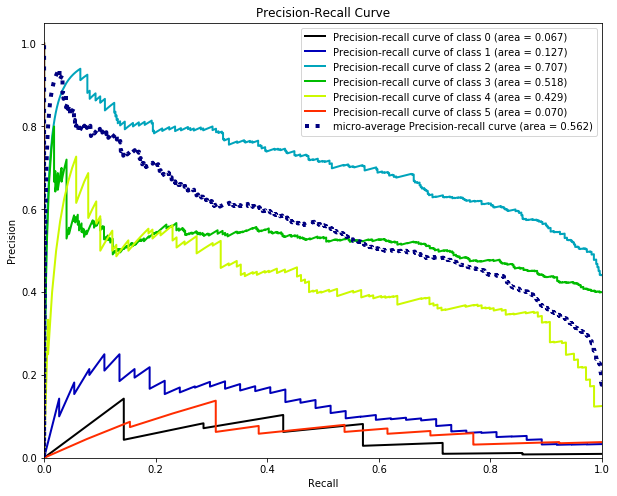

In [82]:
fig, ax = plt.subplots(figsize=(10, 8))
skplt.metrics.plot_precision_recall_curve(y_test, lr2_probas, ax=ax)

In [115]:
lr3 = LogisticRegression(C=1e3, 
                         class_weight='balanced', 
                         random_state=129,
                         multi_class='multinomial',
                         solver='newton-cg', max_iter=1000)
lr3.fit(X_train, y_train)

print(lr3)

# make predictions
lr3_pred = lr3.predict(X_test)
lr3_probas = lr3.predict_log_proba(X_test)

# summarize the fit of the model
print(classification_report(y_test, lr3_pred))
print(confusion_matrix(y_test, lr3_pred))

LogisticRegression(C=1000.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=1000,
          multi_class='multinomial', n_jobs=1, penalty='l2',
          random_state=129, solver='newton-cg', tol=0.0001, verbose=0,
          warm_start=False)
             precision    recall  f1-score   support

          0       0.10      0.14      0.12         7
          1       0.12      0.49      0.19        37
          2       0.68      0.60      0.64       477
          3       0.58      0.32      0.41       447
          4       0.36      0.58      0.45       139
          5       0.08      0.38      0.13        13

avg / total       0.57      0.48      0.50      1120

[[  1   3   3   0   0   0]
 [  1  18   9   7   0   2]
 [  2  92 285  77  16   5]
 [  4  40 113 144 117  29]
 [  2   2   8  21  81  25]
 [  0   0   0   0   8   5]]


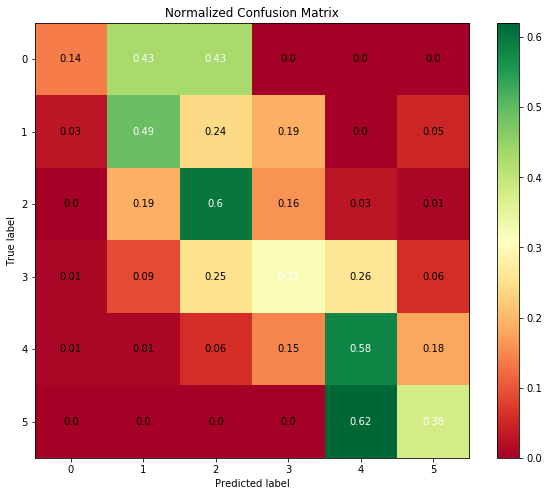

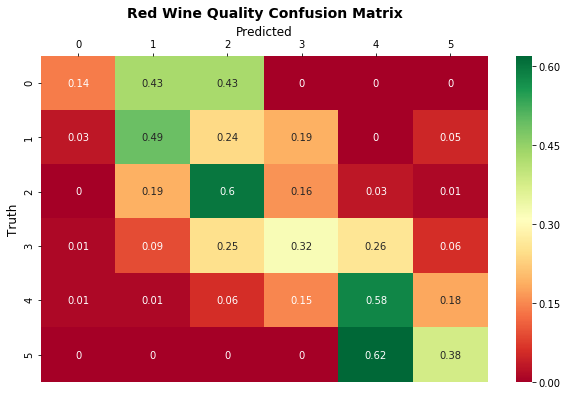

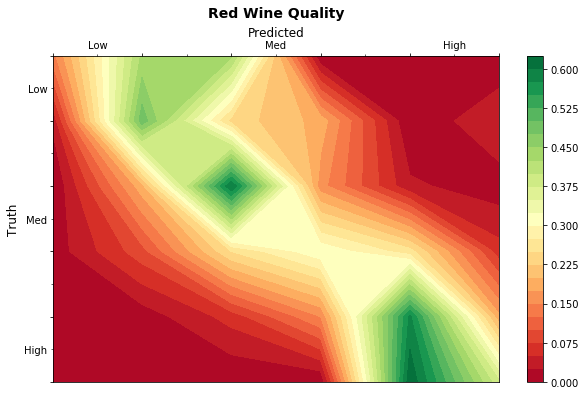

In [157]:
fig, ax = plt.subplots(figsize=(10, 8))
skplt.metrics.plot_confusion_matrix(y_test, lr3_pred, 
                                    normalize=True, cmap='RdYlGn', ax=ax)

discrete_heatmap(confusion_matrix(y_test, lr3_pred))

interpolated_heatmap(confusion_matrix(y_test, lr3_pred))

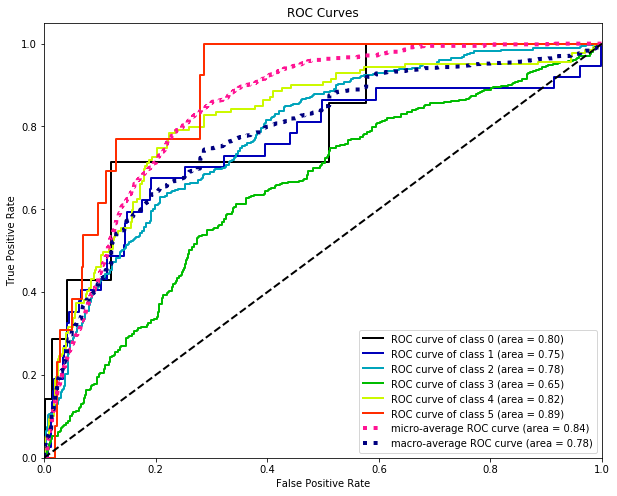

In [99]:
fig, ax = plt.subplots(figsize=(10, 8))
skplt.metrics.plot_roc_curve(y_test, lr3_probas, ax=ax)

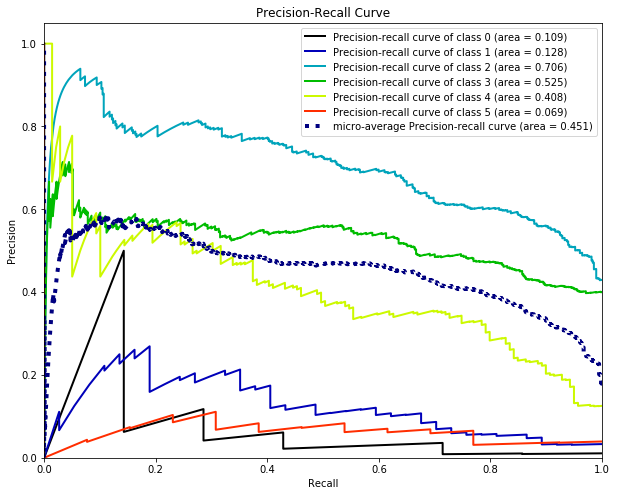

In [100]:
fig, ax = plt.subplots(figsize=(10, 8))
skplt.metrics.plot_precision_recall_curve(y_test, lr3_probas, ax=ax)

In [83]:
lr4 = LogisticRegression(C=1e3, 
                         class_weight='balanced', 
                         random_state=129,
                         multi_class='multinomial',
                         solver='lbfgs')
lr4.fit(X_train, y_train)

print(lr4)

# make predictions
lr4_pred = lr4.predict(X_test)
lr4_probas = lr4.predict_log_proba(X_test)

# summarize the fit of the model
print(classification_report(y_test, lr4_pred))
print(confusion_matrix(y_test, lr4_pred))

LogisticRegression(C=1000.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=1, penalty='l2',
          random_state=129, solver='lbfgs', tol=0.0001, verbose=0,
          warm_start=False)
             precision    recall  f1-score   support

          0       0.00      0.00      0.00         7
          1       0.08      0.49      0.14        37
          2       0.68      0.48      0.56       477
          3       0.52      0.22      0.31       447
          4       0.29      0.31      0.30       139
          5       0.06      0.62      0.11        13

avg / total       0.54      0.36      0.41      1120

[[  0   4   3   0   0   0]
 [  3  18   9   4   1   2]
 [ 24 117 230  76  21   9]
 [ 41  79  91 100  77  59]
 [ 15   4   6  13  43  58]
 [  0   1   0   0   4   8]]


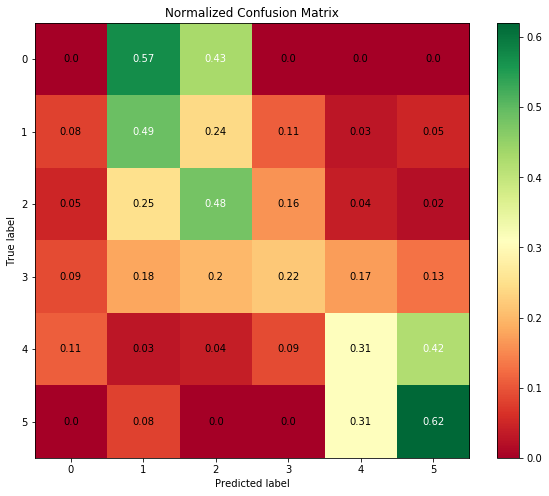

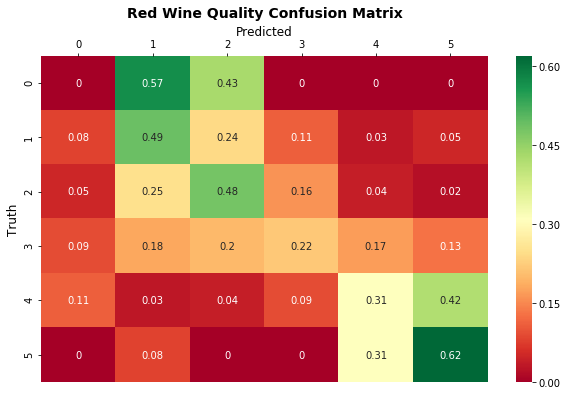

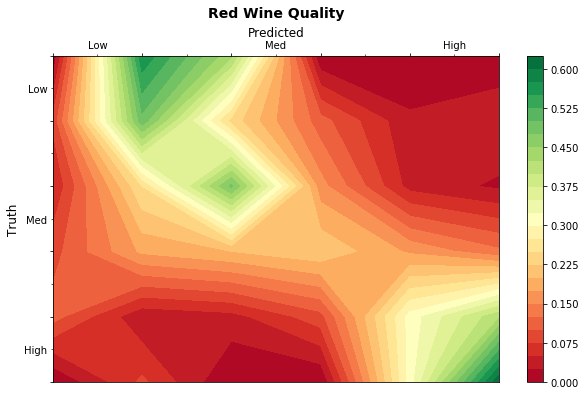

In [158]:
fig, ax = plt.subplots(figsize=(10, 8))
skplt.metrics.plot_confusion_matrix(y_test, lr4_pred, 
                                    normalize=True, cmap='RdYlGn', ax=ax)

discrete_heatmap(confusion_matrix(y_test, lr4_pred))

interpolated_heatmap(confusion_matrix(y_test, lr4_pred))

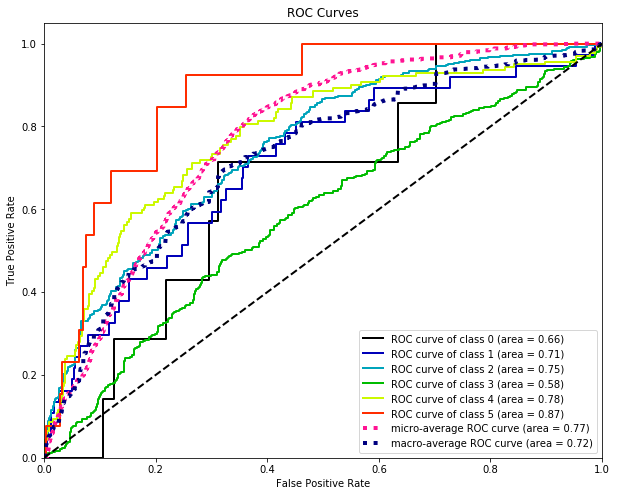

In [101]:
fig, ax = plt.subplots(figsize=(10, 8))
skplt.metrics.plot_roc_curve(y_test, lr4_probas, ax=ax)

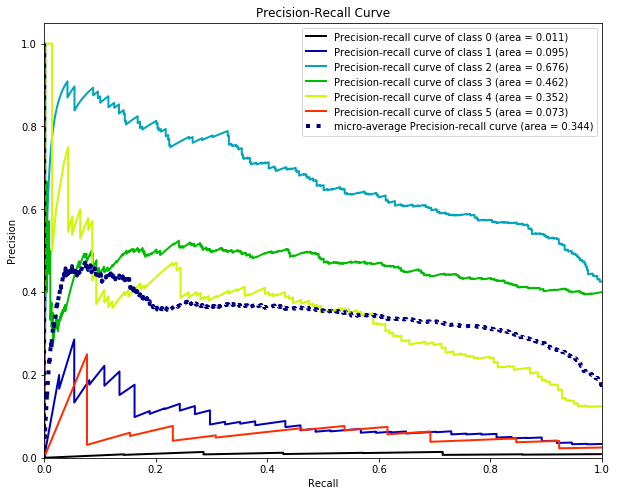

In [102]:
fig, ax = plt.subplots(figsize=(10, 8))
skplt.metrics.plot_precision_recall_curve(y_test, lr4_probas, ax=ax)

In [123]:
lr5 = LogisticRegression(C=1e3, 
                         class_weight='balanced', 
                         random_state=129,
                         multi_class='multinomial',
                         solver='sag',
                         max_iter=10000*2.5)
lr5.fit(X_train, y_train)

print(lr5)

# make predictions
lr5_pred = lr5.predict(X_test)
lr5_probas = lr5.predict_log_proba(X_test)

# summarize the fit of the model
print(classification_report(y_test, lr5_pred))
print(confusion_matrix(y_test, lr5_pred))

LogisticRegression(C=1000.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=25000.0,
          multi_class='multinomial', n_jobs=1, penalty='l2',
          random_state=129, solver='sag', tol=0.0001, verbose=0,
          warm_start=False)
             precision    recall  f1-score   support

          0       0.00      0.00      0.00         7
          1       0.09      0.43      0.15        37
          2       0.67      0.52      0.59       477
          3       0.55      0.29      0.38       447
          4       0.34      0.51      0.41       139
          5       0.07      0.46      0.12        13

avg / total       0.55      0.42      0.46      1120

[[  0   4   3   0   0   0]
 [  1  16  12   7   0   1]
 [ 14 105 249  83  18   8]
 [ 18  52 102 130 111  34]
 [  4   1   6  16  71  41]
 [  0   0   0   0   7   6]]


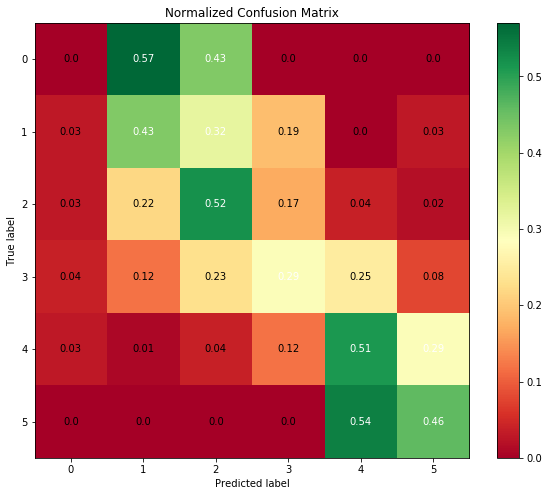

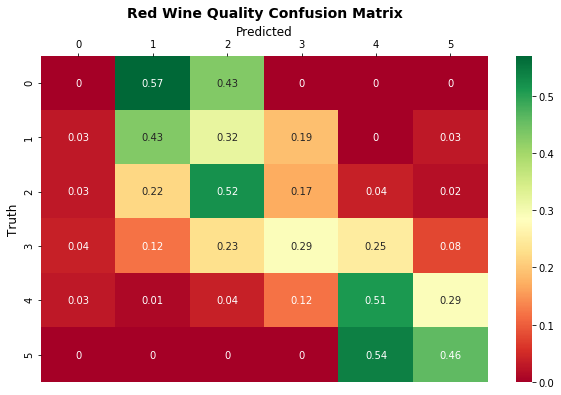

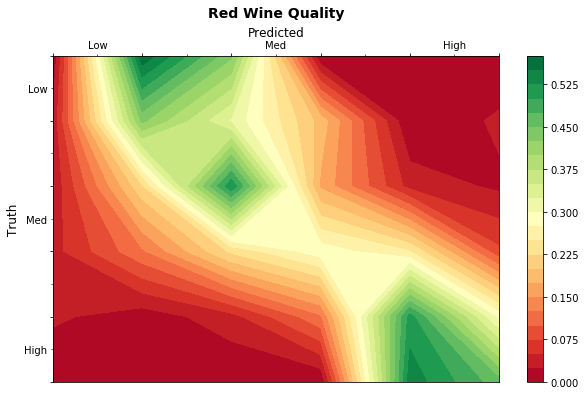

In [159]:
fig, ax = plt.subplots(figsize=(10, 8))
skplt.metrics.plot_confusion_matrix(y_test, lr5_pred, 
                                    normalize=True, cmap='RdYlGn', ax=ax)

discrete_heatmap(confusion_matrix(y_test, lr5_pred))

interpolated_heatmap(confusion_matrix(y_test, lr5_pred))

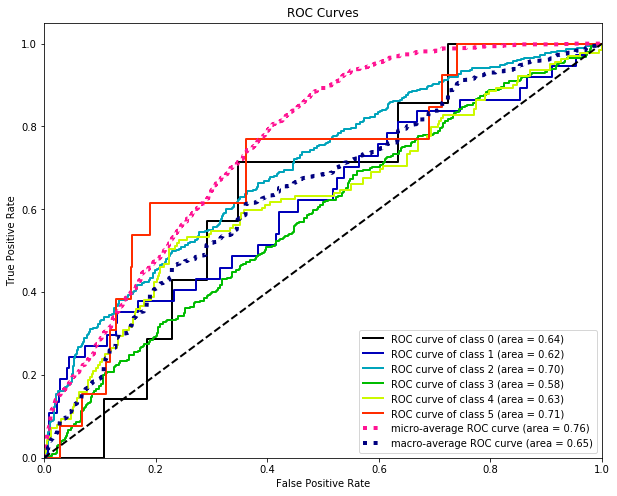

In [103]:
fig, ax = plt.subplots(figsize=(10, 8))
skplt.metrics.plot_roc_curve(y_test, lr5_probas, ax=ax)

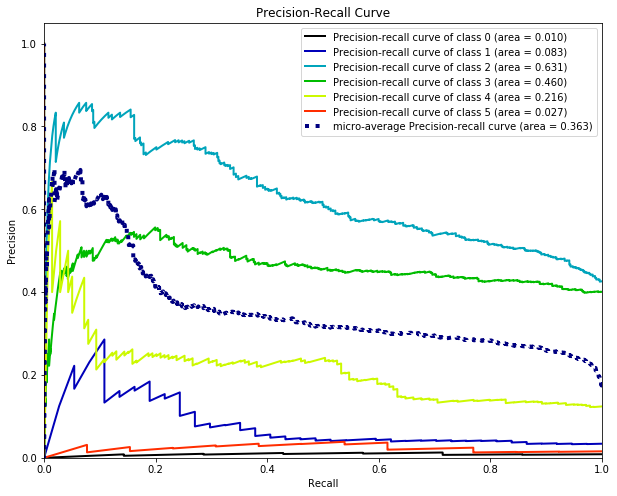

In [104]:
fig, ax = plt.subplots(figsize=(10, 8))
skplt.metrics.plot_precision_recall_curve(y_test, lr5_probas, ax=ax)

In [125]:
lr6 = LogisticRegression(C=1e3, 
                         class_weight='balanced', 
                         random_state=129,
                         multi_class='multinomial',
                         solver='saga',
                         max_iter=10000*2.5)
lr6.fit(X_train, y_train)

print(lr6)

# make predictions
lr6_pred = lr6.predict(X_test)
lr6_probas = lr6.predict_log_proba(X_test)

# summarize the fit of the model
print(classification_report(y_test, lr6_pred))
print(confusion_matrix(y_test, lr6_pred))

LogisticRegression(C=1000.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=25000.0,
          multi_class='multinomial', n_jobs=1, penalty='l2',
          random_state=129, solver='saga', tol=0.0001, verbose=0,
          warm_start=False)
             precision    recall  f1-score   support

          0       0.00      0.00      0.00         7
          1       0.10      0.46      0.16        37
          2       0.66      0.53      0.59       477
          3       0.56      0.29      0.38       447
          4       0.35      0.48      0.41       139
          5       0.06      0.46      0.11        13

avg / total       0.55      0.42      0.46      1120

[[  0   4   3   0   0   0]
 [  1  17  12   6   0   1]
 [ 15 104 252  81  17   8]
 [ 19  52 109 128  98  41]
 [  5   1   7  15  67  44]
 [  0   0   0   0   7   6]]


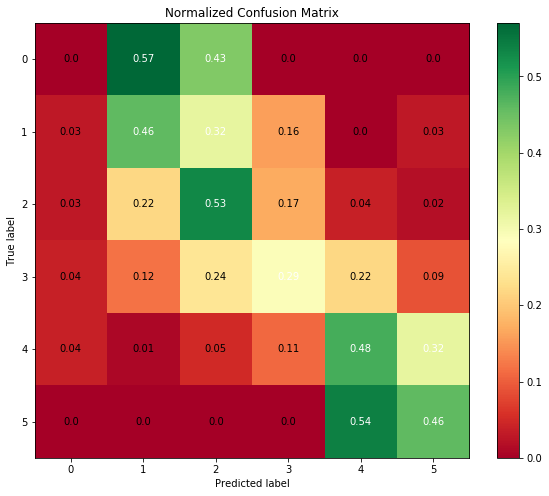

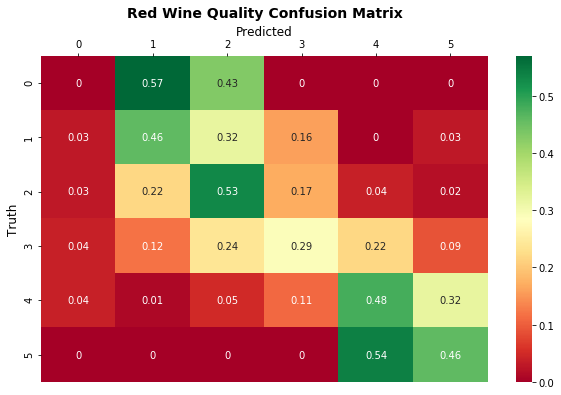

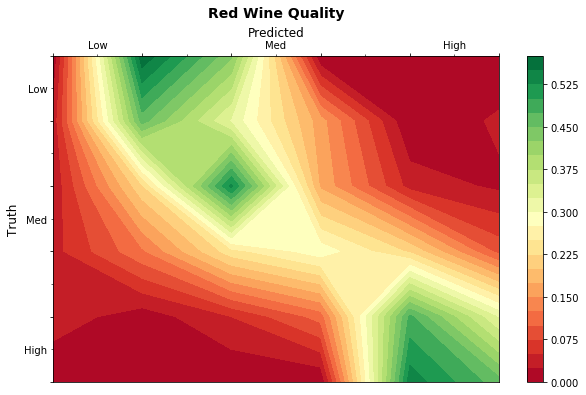

In [160]:
fig, ax = plt.subplots(figsize=(10, 8))
skplt.metrics.plot_confusion_matrix(y_test, lr6_pred, 
                                    normalize=True, cmap='RdYlGn', ax=ax)

discrete_heatmap(confusion_matrix(y_test, lr6_pred))

interpolated_heatmap(confusion_matrix(y_test, lr6_pred))

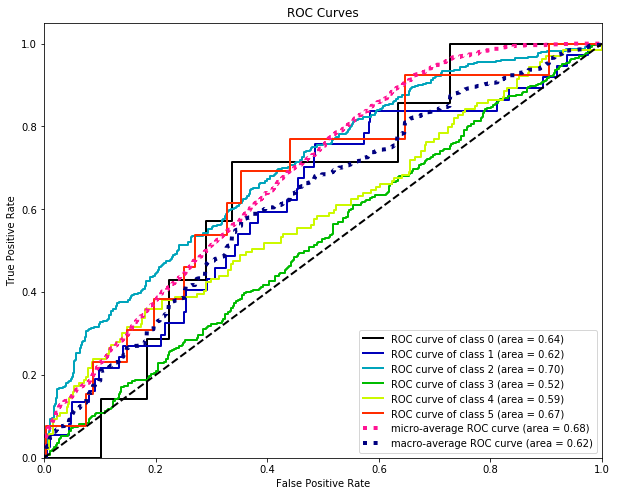

In [105]:
fig, ax = plt.subplots(figsize=(10, 8))
skplt.metrics.plot_roc_curve(y_test, lr6_probas, ax=ax)

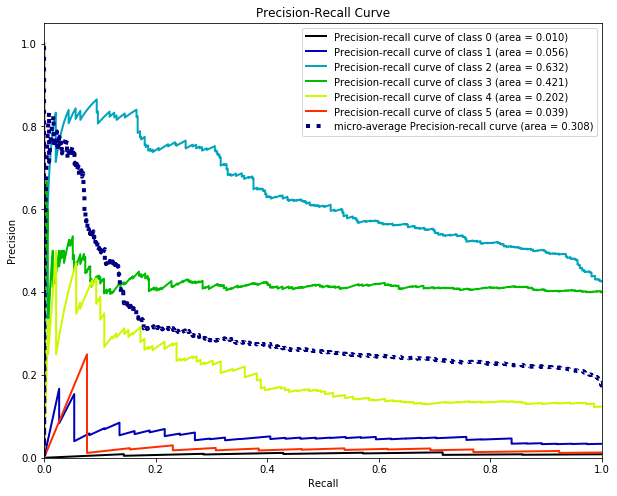

In [106]:
fig, ax = plt.subplots(figsize=(10, 8))
skplt.metrics.plot_precision_recall_curve(y_test, lr6_probas, ax=ax)

### Plot ROC Curves

In [16]:
from sklearn.preprocessing import LabelBinarizer

In [17]:
# Binarize the output
classes = sorted(y.unique())
print(classes)
# y2 = label_binarize(y, classes=classes)
lb = LabelBinarizer()
y2 = lb.fit_transform(y)
n_classes = y2.shape[1]
# Resplit using same seed
X_train, X_test, y_train, y_test = train_test_split(X, y2, test_size=.7, random_state=129)

[0, 1, 2, 3, 4, 5]


In [43]:
# Learn to predict each class against the other
classifier = OneVsRestClassifier(LogisticRegression(C=1000, class_weight='balanced', random_state=129))
y_score = classifier.fit(X_train, y_train).decision_function(X_test)
y_pred = classifier.predict(X_test)
y_probas = classifier.predict_proba(X_test)

print(classifier)
# print(classification_report(y_test, y_pred))
print(classification_report(lb.inverse_transform(y_test), lb.inverse_transform(y_pred)))
print(confusion_matrix(lb.inverse_transform(y_test), lb.inverse_transform(y_pred)))

OneVsRestClassifier(estimator=LogisticRegression(C=1000, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=129,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
          n_jobs=1)
             precision    recall  f1-score   support

          0       0.03      0.25      0.06         8
          1       0.07      0.40      0.12        43
          2       0.62      0.46      0.53       489
          3       0.55      0.50      0.52       443
          4       0.30      0.10      0.15       127
          5       0.00      0.00      0.00        10

avg / total       0.52      0.43      0.46      1120

[[  2   4   2   0   0   0]
 [  5  17  15   6   0   0]
 [ 21 161 226  70  11   0]
 [ 34  60 111 220  18   0]
 [  1   3  12  97  13   1]
 [  0   0   0   9   1   0]]


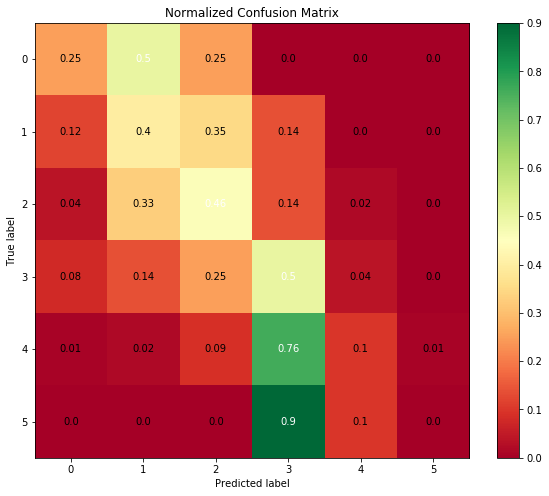

In [52]:
fig, ax = plt.subplots(figsize=(10, 8))
skplt.metrics.plot_confusion_matrix(lb.inverse_transform(y_test), 
                                    lb.inverse_transform(y_pred), 
                                    normalize=True, cmap='RdYlGn', ax=ax)

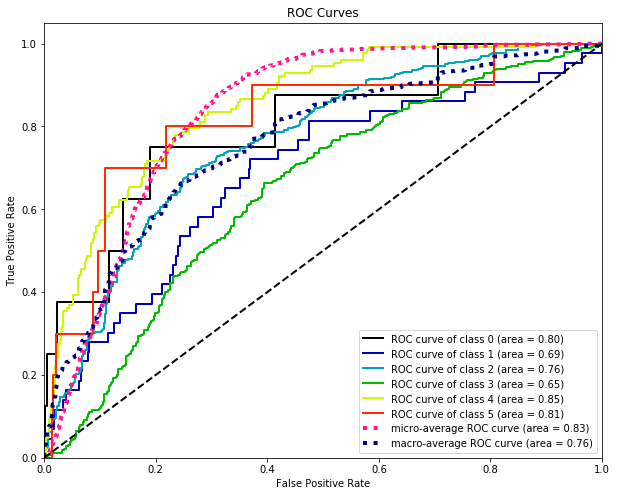

In [51]:
fig, ax = plt.subplots(figsize=(10, 8))
skplt.metrics.plot_roc_curve(lb.inverse_transform(y_test), y_probas, ax=ax)

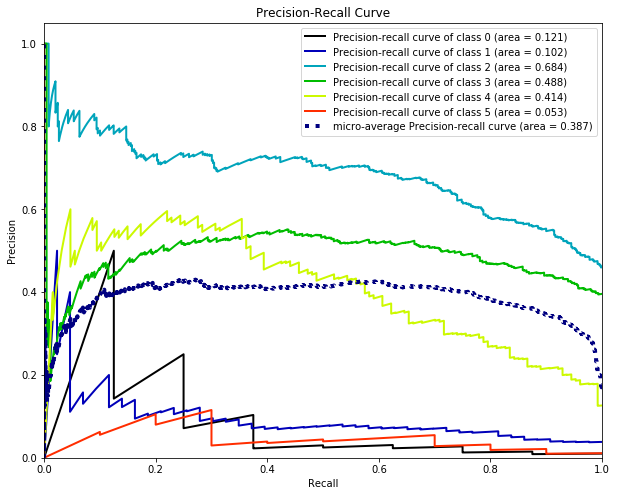

In [50]:
fig, ax = plt.subplots(figsize=(10, 8))
skplt.metrics.plot_precision_recall_curve(lb.inverse_transform(y_test), y_probas, ax=ax)

In [55]:
skplt.metrics.plot_calibration_curve([lb.inverse_transform(y_test)], [y_probas])

ValueError: plot_calibration_curve only works for binary classification

In [20]:
# Plot Classification Report
import matplotlib.pyplot as plt
import numpy as np

def show_values(pc, fmt="%.2f", **kw):
    '''
    Heatmap with text in each cell with matplotlib's pyplot
    Source: https://stackoverflow.com/a/25074150/395857 
    By HYRY
    '''
    pc.update_scalarmappable()
#     ax = pc.gca()
    for p, color, value in zip(pc.get_paths(), pc.get_facecolors(), pc.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.all(color[:3] > 0.5):
            color = (0.0, 0.0, 0.0)
        else:
            color = (1.0, 1.0, 1.0)
        ax.text(x, y, fmt % value, ha="center", va="center", color=color, **kw)


def cm2inch(*tupl):
    '''
    Specify figure size in centimeter in matplotlib
    Source: https://stackoverflow.com/a/22787457/395857
    By gns-ank
    '''
    inch = 2.54
    if type(tupl[0]) == tuple:
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)


def heatmap(AUC, title, xlabel, ylabel, xticklabels, yticklabels, figure_width=40, figure_height=20, correct_orientation=False, cmap='RdBu'):
    '''
    Inspired by:
    - https://stackoverflow.com/a/16124677/395857 
    - https://stackoverflow.com/a/25074150/395857
    '''

    # Plot it out
#     fig, ax = plt.subplots()    
    fig, ax = plt.subplots(figsize=(8, 6))
    
    #c = ax.pcolor(AUC, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap='RdBu', vmin=0.0, vmax=1.0)
    c = ax.pcolor(AUC, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap=cmap)

    # put the major ticks at the middle of each cell
    ax.set_yticks(np.arange(AUC.shape[0]) + 0.5, minor=False)
    ax.set_xticks(np.arange(AUC.shape[1]) + 0.5, minor=False)

    # set tick labels
    #ax.set_xticklabels(np.arange(1,AUC.shape[1]+1), minor=False)
    ax.set_xticklabels(xticklabels, minor=False)
    ax.set_yticklabels(yticklabels, minor=False)

    # set title and x/y labels
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)      

    ax.set_title('Red Wine Quality Classification Report\n\n', fontdict={'size': 14, 'weight': 'bold'})
    ax.xaxis.set_ticks_position('top') 
    ax.xaxis.set_label_position('top')
    
    # Remove last blank column
    plt.xlim( (0, AUC.shape[1]) )

    # Turn off all the ticks
    ax = plt.gca()    
    for t in ax.xaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False
    for t in ax.yaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False

    # Add color bar
    plt.colorbar(c)

    # Add text in each cell 
    show_values(c)

    # Proper orientation (origin at the top left instead of bottom left)
    if correct_orientation:
        ax.invert_yaxis()
        ax.xaxis.tick_top()       

    # resize 
    fig = plt.gcf()
    #fig.set_size_inches(cm2inch(40, 20))
    #fig.set_size_inches(cm2inch(40*4, 20*4))
    fig.set_size_inches(cm2inch(figure_width, figure_height))



def plot_classification_report(classification_report, title='Classification report ', cmap='RdYlGn'):
    '''
    Plot scikit-learn classification report.
    Extension based on https://stackoverflow.com/a/31689645/395857 
    '''
    lines = classification_report.split('\n')

    classes = []
    plotMat = []
    support = []
    class_names = []
    for line in lines[2 : (len(lines) - 2)]:
        t = line.strip().split()
        if len(t) < 2: continue
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        support.append(int(t[-1]))
        class_names.append(t[0])
        print(v)
        plotMat.append(v)

    print('plotMat: {0}'.format(plotMat))
    print('support: {0}'.format(support))

    xlabel = 'Metrics'
    ylabel = 'Quality'
    
    xticklabels = ['Precision', 'Recall', 'F1-score']
    
    
#     yticklabels = ['{0} ({1})'.format(class_names[idx], sup) for idx, sup  in enumerate(support)]
    yticklabels = ['{0}'.format(class_names[idx]) for idx in range(len(support))]
    figure_width = 25
    figure_height = len(class_names) + 7
    correct_orientation = False
#     heatmap(np.flipud(np.array(plotMat)), title, xlabel, ylabel, xticklabels, np.flipud(yticklabels), figure_width, figure_height, correct_orientation, cmap=cmap)
   
    heatmap(np.array(plotMat), title, xlabel, ylabel, xticklabels, yticklabels, figure_width, figure_height, correct_orientation, cmap=cmap)
    
    

[0.09, 0.25, 0.13]
[0.07, 0.44, 0.12]
[0.64, 0.74, 0.68]
[0.52, 0.61, 0.56]
[0.3, 0.75, 0.43]
[0.05, 0.7, 0.1]
plotMat: [[0.09, 0.25, 0.13], [0.07, 0.44, 0.12], [0.64, 0.74, 0.68], [0.52, 0.61, 0.56], [0.3, 0.75, 0.43], [0.05, 0.7, 0.1]]
support: [8, 43, 489, 443, 127, 10]


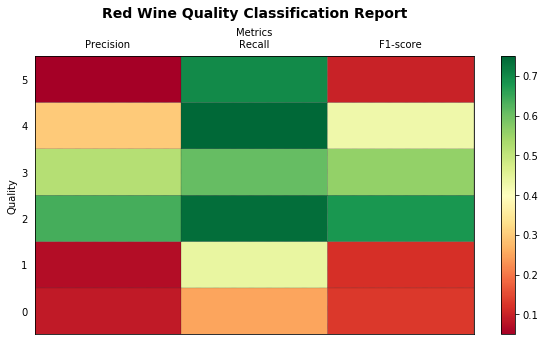

In [21]:
plot_classification_report(cr);
# plt.savefig('test_plot_classif_report.png', dpi=200, format='png', bbox_inches='tight')
# plt.close()

Text(0.5,1,'Red Wine Quality Confusion Matrix\n\n')

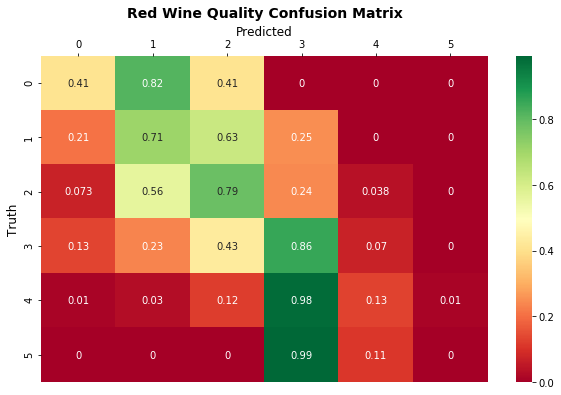

In [32]:
### Discrete Confusion Matrix Heatmap
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(10, 6))

# Generate confusion matrix
# Z = confusion_matrix(y_test, y_pred)
Z = confusion_matrix(lb.inverse_transform(y_test), lb.inverse_transform(y_pred))
# Normalize across predictions
norm_Z = normalize(Z, axis=1)

# Generate heatmap
sns.heatmap(norm_Z, cmap='RdYlGn', annot=True, cbar=True)

## Format axes object
#  Format X-axis label and ticks
ax.set_xlabel('Predicted', fontdict={'size': 12})
ax.xaxis.set_ticks_position('top') 
ax.xaxis.set_label_position('top')
# Format Y-axis label
ax.set_ylabel('Truth', fontdict={'size': 12})
# Format Title [Note: double newlines are to create space between Title and the X-axis label that was moved to the top]
ax.set_title('Red Wine Quality Confusion Matrix\n\n', fontdict={'size': 14, 'weight': 'bold'})

Text(0.5,1,'Red Wine Quality\n\n')

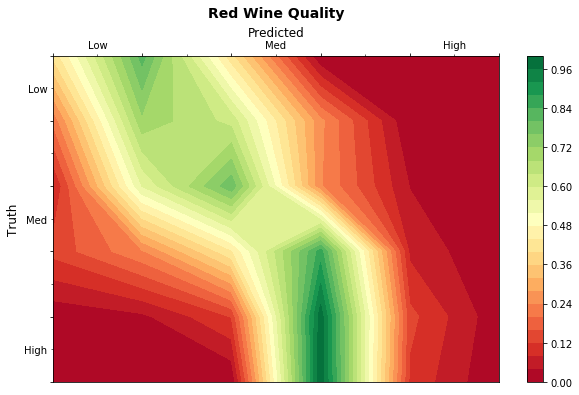

In [61]:
### Interpolated Confusion Matrix Heatmap
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(10, 6))

# Generate confusion matrix
# Z = confusion_matrix(y_test, y_pred)
Z = confusion_matrix(lb.inverse_transform(y_test), lb.inverse_transform(y_pred))
# Normalize across predictions [Note: Use this if classes are imbalanced]
norm_Z = normalize(Z, axis=1)
# Normalize across predictions and truth [Note: Use this if classes are balanced]
# norm_Z = (Z - np.min(Z)) / (np.max(Z) - np.min(Z))

# Generate X, Y indices of confusion matrix
n_classes = norm_Z.shape[0]
X, Y = np.meshgrid(np.arange(0, n_classes, 1), np.arange(n_classes-1, -1, -1))

# Plot contours
plt.contourf(X, Y, norm_Z, 25, cmap='RdYlGn', vmin=0, vmax=1)
ax2 = plt.colorbar();

## Format X-axis label and ticks
ax.set_xlabel('Predicted', fontdict={'size': 12})
# Move ticks and label to top
ax.xaxis.set_ticks_position('top') 
ax.xaxis.set_label_position('top')
# Hide major tick labels
ax.set_xticklabels([], minor=False) 
# Create minor ticks in between and label every other one
ax.set_xticks([0.5, 1.5, 2.5, 3.5, 4.5], minor=True)
ax.set_xticklabels(['Low', '', 'Med', '', 'High'], minor=True)

## Format Y-axis label and ticks
ax.set_ylabel('Truth', fontdict={'size': 12})
# Hide major tick labels
ax.set_yticklabels([], minor=False)
# Create minor ticks in between and label every other one
ax.set_yticks([0.5, 1.5, 2.5, 3.5, 4.5], minor=True)
ax.set_yticklabels(['High', '', 'Med', '', 'Low'], minor=True)

# Format Title [Note: double newlines are to create space between Title and the X-axis label that was moved to the top]
ax.set_title('Red Wine Quality\n\n', fontdict={'size': 14, 'weight': 'bold'})

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
plt.contourf(X, Y, norm_Z, 25, cmap='Greens', vmin=0, vmax=1)
ax2 = plt.colorbar();

ax.xaxis.set_ticks_position('top') 
ax.xaxis.set_label_position('top')

ax.set_xticks([0.5, 1.5, 2.5, 3.5, 4.5], minor=True)
ax.set_xticklabels(['Low', '', 'Med', '', 'High'], minor=True)
ax.set_xticklabels([], minor=False)

ax.set_yticks([0.5, 1.5, 2.5, 3.5, 4.5], minor=True)
ax.set_yticklabels(['High', '', 'Med', '', 'Low'], minor=True)
ax.set_yticklabels([], minor=False)

ax.set_xlabel('Predicted', fontdict={'size': 12})
ax.set_ylabel('Truth', fontdict={'size': 12})
ax.set_title('Red Wine Quality\n\n', fontdict={'size': 14, 'weight': 'bold'})

In [ ]:
# Create the data
rs = np.random.RandomState(1979)
x = rs.randn(500)
g = np.tile(list("ABCDEFGHIJ"), 50)
df = pd.DataFrame(dict(x=lb.inverse_transform(y_pred), g=lb.inverse_transform(y_test)))
# m = df.g.map(ord)
# df["x"] += m

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(df, row="g", hue="g", aspect=15, size=0.8, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "x", clip_on=False, shade=True, alpha=1, lw=1, bw=.2)
# g.map(sns.distplot, "x", kde=False, norm_hist=True)
# g.map(sns.kdeplot, "x", clip_on=False, color="w", lw=2, bw=.2)
g.map(plt.axhline, y=0, lw=1, clip_on=False)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .5, label, fontweight="bold", color=color, 
            ha="left", va="center", transform=ax.transAxes)
    
g.map(label, "x")

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.25)

# Remove axes details that don't play will with overlap
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)
g.fig.tight_layout()

In [ ]:
# from sklearn.preprocessing import normalize
# import scipy

In [ ]:
# f = scipy.interpolate.interp2d(X, Y, Z, kind='linear')
# X1 = np.linspace(0, 5, 50)
# Y1 = np.linspace(0, 5, 50)
# Z1 = f(X1, Y1)

In [ ]:
# fig, ax = plt.subplots(figsize=(10, 6))
# plt.contourf(X1, Y1, Z1, 20, cmap='RdGy')
# plt.colorbar();

# ax.set_xlabel('Predicted', fontdict={'size': 12})
# ax.set_ylabel('Truth', fontdict={'size': 12})
# ax.set_title('Wine Quality Prediction', fontdict={'size': 12, 'weight': 'bold'})

In [ ]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [ ]:
# Compute macro-average ROC curve and ROC area
fig, ax = plt.subplots(figsize=(12, 8))

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes
   
# for i in range(n_classes):
for i in sorted(classes):    
    plt.plot(fpr[i], tpr[i], lw=2, label='Quality {0} (AUC = {1:0.2f})' ''.format(classes[i], roc_auc[i]))    

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

plt.plot(fpr["macro"], tpr["macro"],
         label='Macro-Average (AUC = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

ax.plot([0, 1], [0, 1], 'k--', lw=2)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('FPR', fontdict={'size': 12, 'weight': 'bold'})
ax.set_ylabel('TPR', fontdict={'size': 12, 'weight': 'bold'})
ax.set_title('Red Wine Quality ROC Curves', fontdict={'size': 14, 'weight': 'bold'})
ax.legend(loc="lower right")

In [ ]:
l = [.8, .69, .76, .65, .85, .81]

In [ ]:
# simple mean
np.sum(l) / len(l)

In [ ]:
# harmonic mean
len(l) / np.sum([1/x for x in l])

In [ ]:
# geometric mean
np.prod(l) ** (1/len(l))